<a href="https://colab.research.google.com/github/seiji0203/stock-prices-prediction/blob/master/%E7%AC%AC3%E5%9B%9E_%E6%A0%AA%E4%BE%A1%E4%BA%88%E6%B8%AC_LSTM_ver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 必要なパッケージのインストール
!pip3 install torch==1.6.0+cu101
!pip3 install torchvision==0.7.0+cu101
!pip3 install numpy==1.18.5
!pip3 install matplotlib==3.2.2
!pip3 install scikit-learn==0.23.1
!pip3 install seaborn==0.11.0

ERROR: Could not find a version that satisfies the requirement torch==1.6.0+cu101 (from versions: 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2)
ERROR: No matching distribution found for torch==1.6.0+cu101
ERROR: Could not find a version that satisfies the requirement torchvision==0.7.0+cu101 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.3.0, 0.4.0, 0.4.1, 0.4.2, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.8.0, 0.8.1, 0.8.2, 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.11.0, 0.11.1, 0.11.2, 0.11.3)
ERROR: No matching distribution found for torchvision==0.7.0+cu101
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are in

     |████████████████████████████████| 6.8 MB 7.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.1 which is incompatible.
     |████████████████████████████████| 283 kB 31.9 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [2]:
# モジュールのインポート
import numpy as np
import pandas as pd
import pandas_datareader.data as data
from matplotlib import pyplot as plt
%matplotlib inline

# 標準化関数（StandardScaler）をインポート
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

In [3]:
start = '2005-01-01'
end = '2022-01-01'

df = data.DataReader('4689.JP', 'stooq', start, end) 
df.to_csv('Z_Holdings2.csv')

In [4]:
# データの確認
df = pd.read_csv('Z_Holdings2.csv')
df

,Date,Open,High,Low,Close,Volume
0,2021-12-30,646.90,677.00,645.70,667.40,21235600
1,2021-12-29,644.00,649.60,641.90,645.90,7257200
2,2021-12-28,649.20,654.60,643.60,644.00,12849300
3,2021-12-27,656.00,659.50,638.30,640.20,16486400
4,2021-12-24,663.10,690.10,661.70,663.40,18055500
...,...,...,...,...,...,...
4103,2005-03-28,586.38,588.58,557.61,570.88,18962973
4104,2005-03-25,577.54,583.05,573.09,580.85,37678290
4105,2005-03-24,570.88,571.98,566.47,568.68,15077282
4106,2005-03-23,568.68,573.09,565.36,569.77,15162243


In [5]:
# カラムのデータ型の確認、欠損値の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4108 entries, 0 to 4107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4108 non-null   object 
 1   Open    4108 non-null   float64
 2   High    4108 non-null   float64
 3   Low     4108 non-null   float64
 4   Close   4108 non-null   float64
 5   Volume  4108 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 192.7+ KB


In [6]:
# Dateデータがobject型なので、datatime64型へ変更（利便性が高いため）
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4108 entries, 0 to 4107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4108 non-null   datetime64[ns]
 1   Open    4108 non-null   float64       
 2   High    4108 non-null   float64       
 3   Low     4108 non-null   float64       
 4   Close   4108 non-null   float64       
 5   Volume  4108 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 192.7 KB


In [7]:
# 始値(open)、安値(low)、高値(high)、出来高(volume)を消して、終値(close)のみを残す
df = df.drop(['Open', 'Low', 'High', 'Volume'], axis=1)
print(df.head())

        Date  Close
0 2021-12-30  667.4
1 2021-12-29  645.9
2 2021-12-28  644.0
3 2021-12-27  640.2
4 2021-12-24  663.4


In [8]:
# データの並び替え（sort_valuesで日付順に並び替えを行う）
df.sort_values(by='Date', ascending=True, inplace=True)

In [9]:
# 終値の25日移動平均(25MA)を算出
df['25MA'] = df['Close'].rolling(window=25, min_periods=0).mean()
print(df.head())

           Date   Close        25MA
4107 2005-03-22  567.57  567.570000
4106 2005-03-23  569.77  568.670000
4105 2005-03-24  568.68  568.673333
4104 2005-03-25  580.85  571.717500
4103 2005-03-28  570.88  571.550000


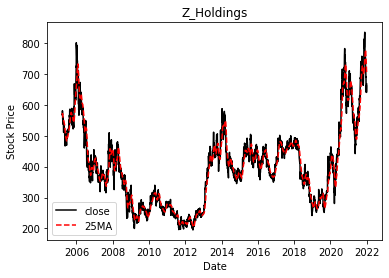

In [10]:
# 終値と25日移動平均を図示
plt.figure()
plt.title('Z_Holdings')
plt.xlabel('Date')
plt.ylabel('Stock Price')
# plt.xticks(np.arange(0, 180 + 1, 30))
# plt.xticks(dataset['date'][::10].values)
plt.plot(df['Date'], df['Close'], color='black',
         linestyle='-', label='close')
plt.plot(df['Date'], df['25MA'], color='red',
         linestyle='--', label='25MA')
plt.legend()  # 凡例
plt.savefig('Z_Holdings.png')  # 図の保存
plt.show()

In [11]:
# 標準化
ma = df['25MA'].values.reshape(-1, 1)
scaler = StandardScaler()
ma_std = scaler.fit_transform(ma)
print("ma: {}".format(ma))
print("ma_std: {}".format(ma_std))

ma: [[567.57      ]
 [568.67      ]
 [568.67333333]
 ...
 [709.188     ]
 [703.144     ]
 [698.568     ]]
ma_std: [[1.35327306]
 [1.36208879]
 [1.3621155 ]
 ...
 [2.48824161]
 [2.4398032 ]
 [2.40312979]]


In [12]:
# 現在から過去25日分の株価の移動平均を入力値として、1日後の株価の移動平均を予測
data = []  # 入力データ(過去25日分の移動平均)
label = []  # 出力データ(1日後の移動平均)
for i in range(len(ma_std) - 25):
    data.append(ma_std[i:i + 25])
    label.append(ma_std[i + 25])
# ndarrayに変換
data = np.array(data)
label = np.array(label)
print("data size: {}".format(data.shape))
print("label size: {}".format(label.shape))

data size: (4083, 25, 1)
label size: (4083, 1)


In [13]:
# 訓練データとテストデータのサイズを決定
test_len = int(252)  # 1年分(252日分)
train_len = int(data.shape[0] - test_len)
# 訓練データの準備
train_data = data[:train_len]
train_label = label[:train_len]
# テストデータの準備
test_data = data[train_len:]
test_label = label[train_len:]
# データの形状を確認
print("train_data size: {}".format(train_data.shape))
print("test_data size: {}".format(test_data.shape))
print("train_label size: {}".format(train_label.shape))
print("test_label size: {}".format(test_label.shape))

train_data size: (3831, 25, 1)
test_data size: (252, 25, 1)
train_label size: (3831, 1)
test_label size: (252, 1)


In [14]:
# ndarrayをPyTorchのTensorに変換
train_x = torch.Tensor(train_data)
test_x = torch.Tensor(test_data)
train_y = torch.Tensor(train_label)
test_y = torch.Tensor(test_label)

In [15]:
# 特徴量とラベルを結合したデータセットを作成
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

In [16]:
# ミニバッチサイズを指定したデータローダーを作成
train_batch = DataLoader(
    dataset=train_dataset,  # データセットの指定
    batch_size=128,  # バッチサイズの指定
    shuffle=True,  # シャッフルするかどうかの指定
    num_workers=2)  # コアの数
test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2)
# ミニバッチデータセットの確認
for data, label in train_batch:
    print("batch data size: {}".format(data.size()))  # バッチの入力データサイズ
    print("batch label size: {}".format(label.size()))  # バッチのラベルサイズ
    break

batch data size: torch.Size([128, 25, 1])
batch label size: torch.Size([128, 1])


In [17]:
# ニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(D_in, H, batch_first=True,
                            num_layers=1)
        self.linear = nn.Linear(H, D_out)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        output = self.linear(output[:, -1, :])  # 最後のステップのみを入力
        return output

In [18]:
# ハイパーパラメータの定義
D_in = 1  # 入力次元: 1
H = 200  # 隠れ層次元: 200
D_out = 1  # 出力次元: 1
epoch = 100  # 学習回数: 100

In [19]:
# ネットワークのロード
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net(D_in, H, D_out).to(device)
# デバイスの確認
print("Device: {}".format(device))

Device: cpu


In [20]:
# 損失関数の定義
criterion = nn.MSELoss()  # 損失関数（平均二乗誤差: MSE）

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())

In [21]:
# 損失を保存するリストを作成
train_loss_list = []  # 学習損失
test_loss_list = []  # 評価損失

# 学習（エポック）の実行
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失の初期化
    train_loss = 0  # 学習損失
    test_loss = 0  # 評価損失

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    for data, label in train_batch:
        # GPUにTensorを転送
        data = data.to(device)
        label = label.to(device)

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred = net(data)
        # 損失（誤差）を計算
        loss = criterion(y_pred, label)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()
        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()

    # ミニバッチの平均の損失を計算
    batch_train_loss = train_loss / len(train_batch)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for data, label in test_batch:
            # GPUにTensorを転送
            data = data.to(device)
            label = label.to(device)
            # データを入力して予測値を計算（順伝播）
            y_pred = net(data)
            # 損失（誤差）を計算
            loss = criterion(y_pred, label)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()

    # ミニバッチの平均の損失を計算
    batch_test_loss = test_loss / len(test_batch)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失を表示
    print("Train_Loss: {:.2E} Test_Loss: {:.2E}".format(
        batch_train_loss, batch_test_loss))
    # 損失をリスト化して保存
    train_loss_list.append(batch_train_loss)
    test_loss_list.append(batch_test_loss)

---------------------------------------------
Epoch: 1/100
Train_Loss: 2.63E-01 Test_Loss: 9.71E-02
---------------------------------------------
Epoch: 2/100
Train_Loss: 1.50E-02 Test_Loss: 5.89E-02
---------------------------------------------
Epoch: 3/100
Train_Loss: 6.78E-03 Test_Loss: 2.16E-02
---------------------------------------------
Epoch: 4/100
Train_Loss: 4.63E-03 Test_Loss: 2.25E-02
---------------------------------------------
Epoch: 5/100
Train_Loss: 3.38E-03 Test_Loss: 5.59E-03
---------------------------------------------
Epoch: 6/100
Train_Loss: 2.38E-03 Test_Loss: 3.46E-03
---------------------------------------------
Epoch: 7/100
Train_Loss: 2.00E-03 Test_Loss: 3.18E-03
---------------------------------------------
Epoch: 8/100
Train_Loss: 1.50E-03 Test_Loss: 2.39E-03
---------------------------------------------
Epoch: 9/100
Train_Loss: 1.28E-03 Test_Loss: 2.57E-03
---------------------------------------------
Epoch: 10/100
Train_Loss: 1.08E-03 Test_Loss: 2.80E-03

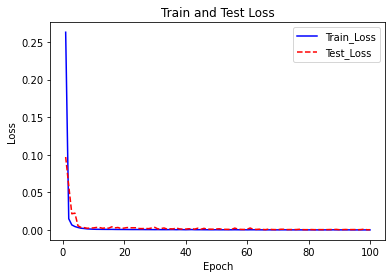

In [22]:
# 損失
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')
plt.legend()  # 凡例
plt.show()  # 表示

In [23]:
# ニューラルネットワークを評価モードに設定
net.eval()
# 推定時の計算で自動微分機能をオフにする
with torch.no_grad():
    # 初期化
    pred_ma = []
    true_ma = []
    for data, label in test_batch:
        # GPUにTensorを転送
        data = data.to(device)
        label = label.to(device)
        # データを入力して予測値を計算（順伝播）
        y_pred = net(data)
        pred_ma.append(y_pred.view(-1).tolist())  # Tensorを1次元listに変換
        true_ma.append(label.view(-1).tolist())

In [24]:
# Tensorを数値データを取り出す
pred_ma = [elem for lst in pred_ma for elem in lst]  # listを1次元配列に
true_ma = [elem for lst in true_ma for elem in lst]

# 標準化を解除して元の株価に変換
pred_ma = scaler.inverse_transform(pred_ma)
true_ma = scaler.inverse_transform(true_ma)

In [25]:
# 平均絶対誤差を計算
mae = mean_absolute_error(true_ma, pred_ma)
print("MAE: {:.3f}".format(mae))

MAE: 2.043


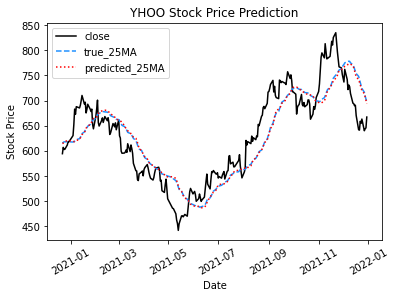

In [26]:
# 終値と25日移動平均を図示
date = df['Date'][-1*test_len:]  # テストデータの日付
test_close = df['Close'][-1*test_len:].values.reshape(-1)  # テストデータの終値
plt.figure()
plt.title('YHOO Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(date, test_close, color='black',
         linestyle='-', label='close')
plt.plot(date, true_ma, color='dodgerblue',
         linestyle='--', label='true_25MA')
plt.plot(date, pred_ma, color='red',
         linestyle=':', label='predicted_25MA')
plt.legend()  # 凡例
plt.xticks(rotation=30)  # x軸ラベルを30度回転して表示
plt.show()